# Basic mutating evolutionary algorithm

In [109]:
import numpy as np
from tqdm import tqdm
import functools
import pandas as pd
from sklearn import decomposition

In [108]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression

In [146]:
D = 50 # number of dimensions
N = D*8 # population size
maximization = False

In [147]:
class StopConditions:
    max_generations = 20

    def count_generations(t):
        return t >= StopConditions.max_generations
    
def stop(t, func = StopConditions.count_generations):
    return func(t)

In [194]:
class ValueFunctions:
    def quadratic(point):
        return functools.reduce(lambda ret, atr: ret + atr*atr, point, 0) / D

def evaluate(point, func = ValueFunctions.quadratic):
    return func(point)

globalOptimum = np.zeros(D)

In [126]:
class Selects:
    theta = 0.2
    
    def threshold(P):
        index = np.random.randint(0, int(Selects.theta*N))
        return P[index]

def select(P, func = Selects.threshold):
    return func(P)

In [127]:
class Mutations:
    variance = 0.2
    
    def gaussian(point_with_fitness):
        point, fitness = point_with_fitness
        noise = np.random.normal(loc=np.zeros(D), scale=Mutations.variance, size=(D,))
        return np.add(point, noise)

def mutation(point_with_fitness, func = Mutations.gaussian):
    return func(point_with_fitness)

In [166]:
# generate initial population
initial_mean = 10.
scale = 2.0 # variance/scale
size = (N,D)
H = np.empty(0)
population = np.random.normal(loc=initial_mean, scale=scale, size=size)
H = np.array([population])

In [167]:
# algorithm
t = 0
with tqdm(total=StopConditions.max_generations) as bar:
    while not stop(t):
        offspring = None
        for i in range(N):
            population_with_fitness = map(lambda point: (point, evaluate(point)), population)
            sorted_population_with_fitness = sorted(population_with_fitness, key=lambda x: x[1], reverse=maximization)
            child = mutation(select(sorted_population_with_fitness))
            offspring = np.append(offspring, [child], axis=0) if offspring is not None else np.array([child])
        population = offspring
        H = np.append(H, np.array([population]), axis=0)
        bar.update(1)
        t += 1

100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


In [130]:
np.save(f"out/evolution-dim={D}-mu={N}-generations={StopConditions.max_generations}.npy", H, fix_imports=False)

In [143]:
def plot_distribution(population):
    if D > 2:
        pca = decomposition.PCA(n_components=2)
        mapping = pca.fit_transform(population)
        x = mapping[:,0]
        y = mapping[:,1]
    else:
        x = population[:,0]
        y = population[:,1]
    plt.scatter(x, y)
    plt.title("Population distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

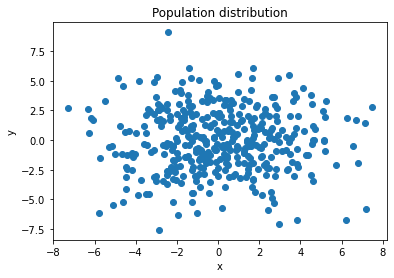

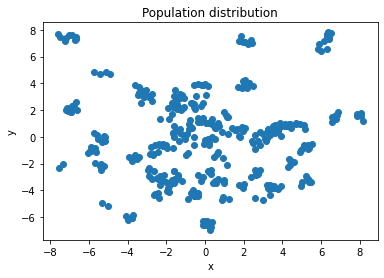

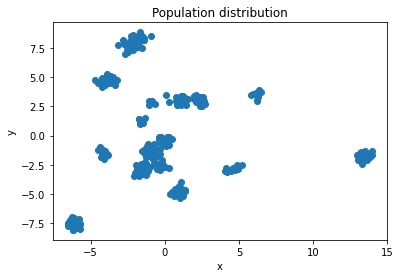

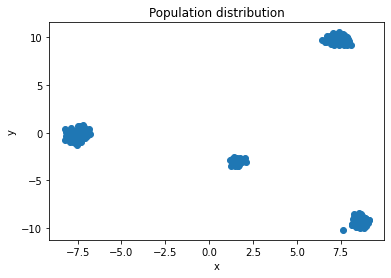

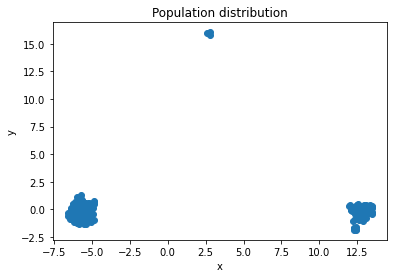

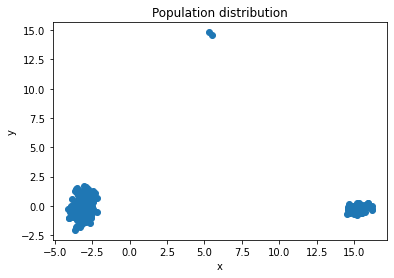

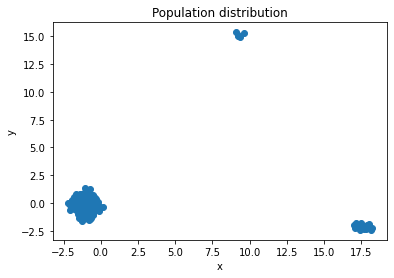

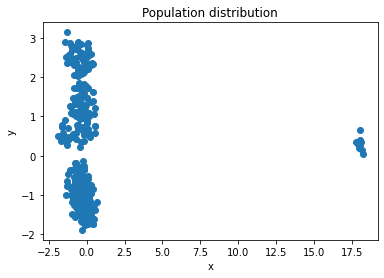

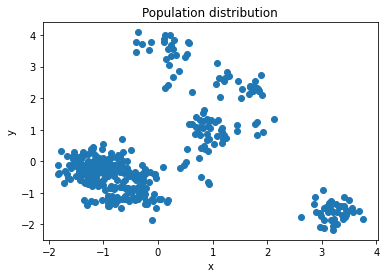

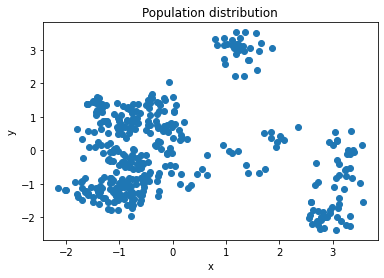

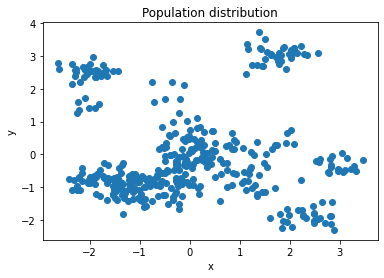

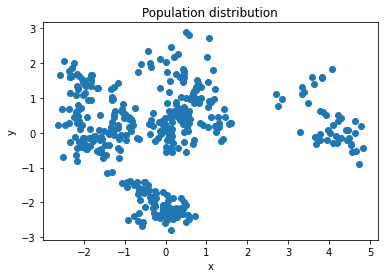

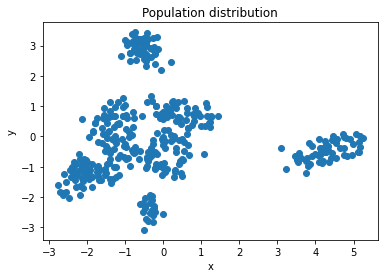

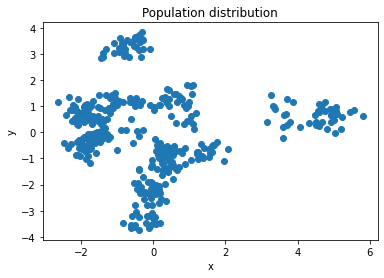

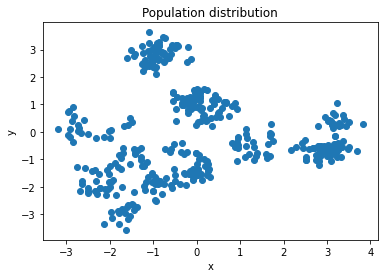

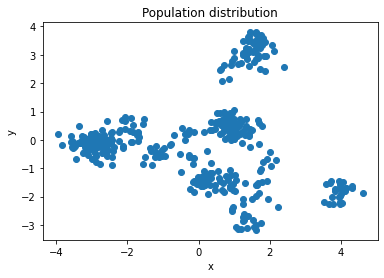

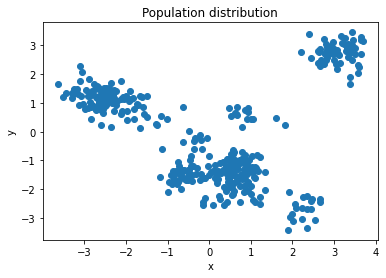

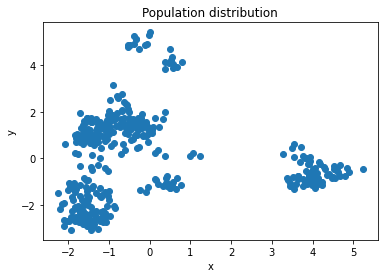

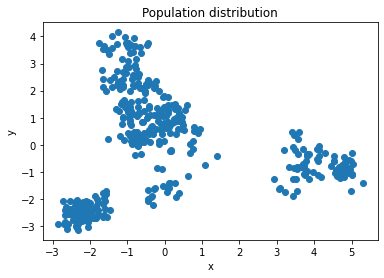

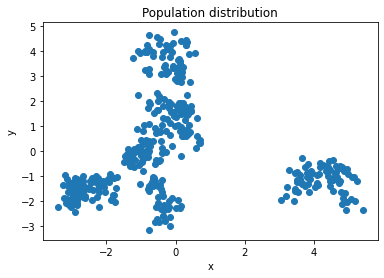

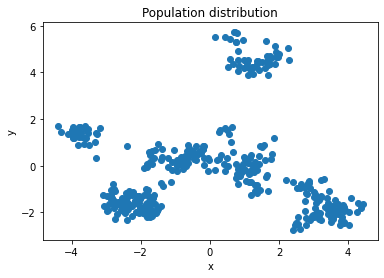

In [168]:
for population in H:
    plot_distribution(population)

In [169]:
def getCentralPoint(population):
    return np.mean(population, axis=0)

In [178]:
def getSequence(population):
    def sortByValue(point):
        return evaluate(point)
    tmpPopulation = sorted(population.copy(), key=sortByValue)
    centroidSequence = []
    while len(tmpPopulation):
        centroidSequence.append(getCentralPoint(tmpPopulation))
        # print(evaluate(tmpPopulation[-1]))
        del tmpPopulation[-1]
    return np.array(centroidSequence)

In [188]:
def plot_centroid_sequence(population):
    centroidSequence = getSequence(population)
    index = np.linspace(0,1,N)
    cmap = plt.cm.Greens
    color = cmap(index)
    if D > 2:
        pca = decomposition.PCA(n_components=2)
        mapping = pca.fit_transform(centroidSequence)
        x = mapping[:,0]
        y = mapping[:,1]
    else:
        x = centroidSequence[:,0]
        y = centroidSequence[:,1]
    plt.scatter(x, y, c=color)
    plt.title("Centroid sequence, dim reduced to 2")
    plt.xlabel("latent x")
    plt.ylabel("latent y")
    norm = mpl.colors.Normalize(vmin=0, vmax=N)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='sequence index')
    plt.show()

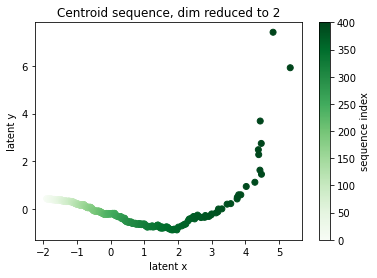

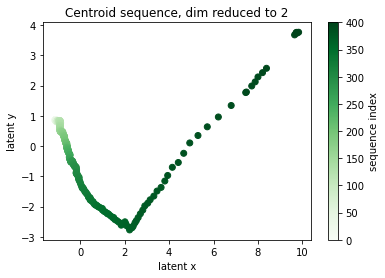

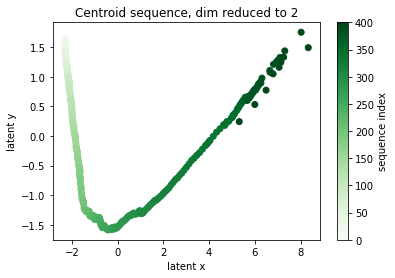

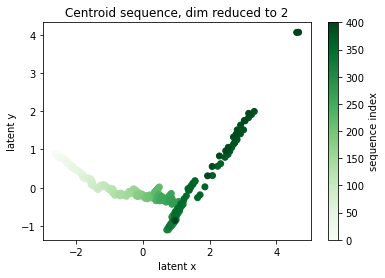

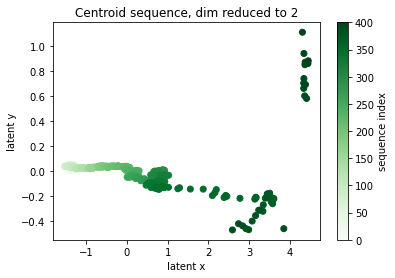

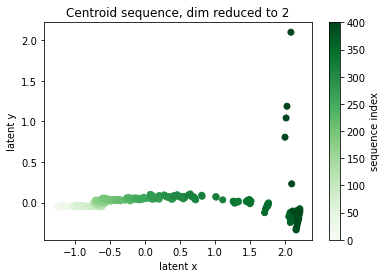

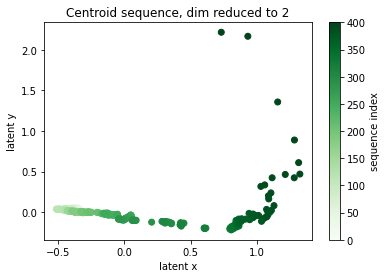

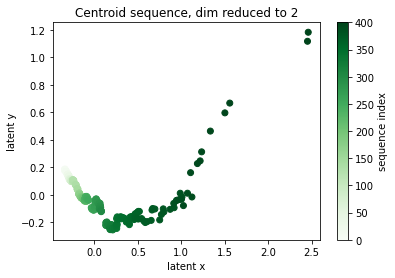

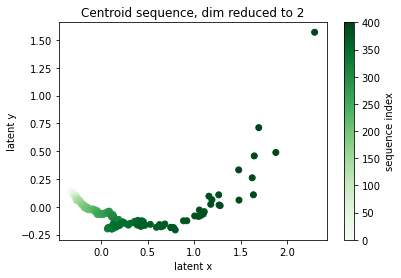

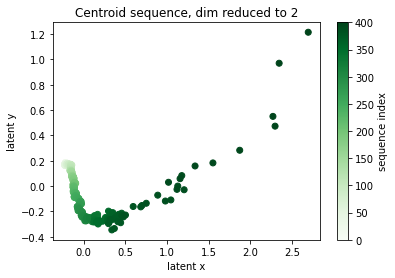

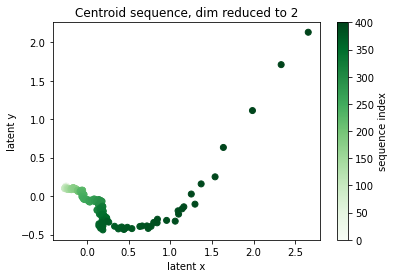

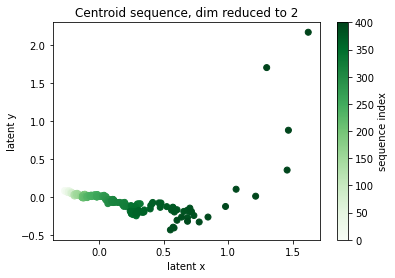

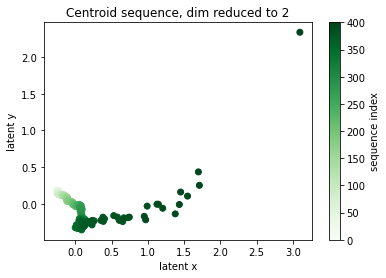

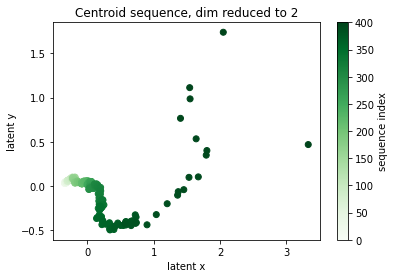

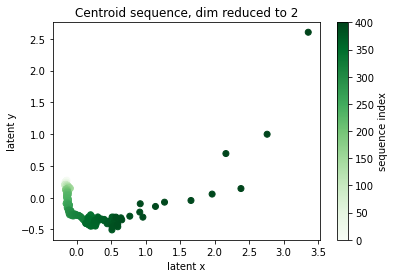

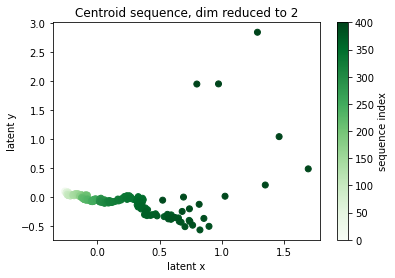

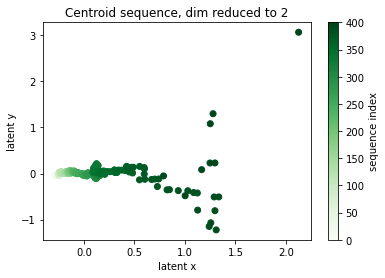

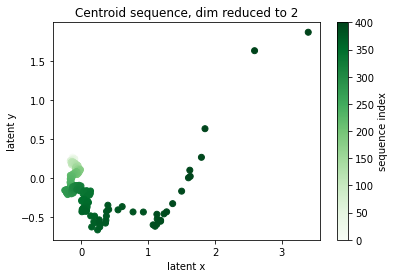

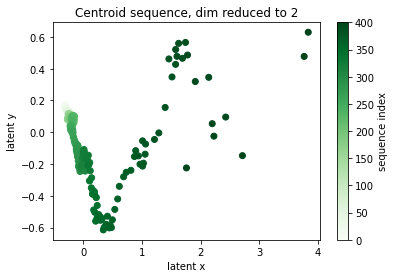

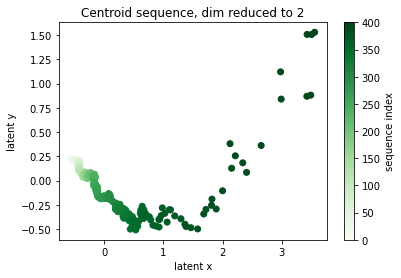

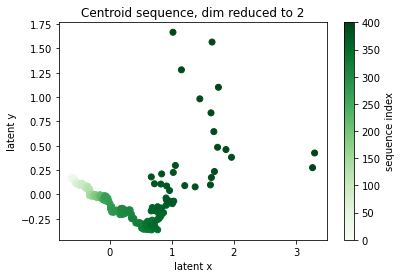

In [209]:
for population in H:
    plot_centroid_sequence(population)

In [207]:
def plot_method_performance(population):
    centroidSequence = getSequence(population)
    index = np.linspace(0,1,N)
    cmap = plt.cm.Greens
    color = cmap(index)
    df = pd.DataFrame({
        'x': centroidSequence[:,0],
        'y': centroidSequence[:,1],
        'value': map(evaluate, centroidSequence),
        'dist_from_opt': map(lambda point: np.linalg.norm(point - globalOptimum), centroidSequence)
    })
    samples = index.reshape(-1,1)
    estimator_point = []
    for i in range(D):
        targets = centroidSequence[:, i].copy().reshape(-1,1)
        regression_model = LinearRegression().fit(samples, targets)
        estimator_point.append(regression_model.predict([[1]])[0][0])
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    vc = mlines.Line2D([], [], color='g', marker='o', linestyle='None')
    ve = mlines.Line2D([], [], color='g', marker='x', linestyle='None')
    dc = mlines.Line2D([], [], color='r')
    de = mlines.Line2D([], [], color='r', linestyle='dotted')

    plt.title('Centroid sequence method performance')
    ax1.set_xlabel('sequence index')
    ax1.set_ylabel('Point value', color='g')
    ax1.scatter(index*N, df.value, c=color, label='centroid')
    ax1.plot(N, evaluate(estimator_point), 'gx', label='estimator')
    ax2.set_ylabel('Euclidean distance from optimum', color='r')
    ax2.plot(index*N, df.dist_from_opt, color='r', label='centroid')
    ax2.axhline(y=np.linalg.norm(estimator_point - globalOptimum), color='r', linestyle='dashed', label='estimator')
    # plt.legend()
    plt.legend(handles=[vc,ve,dc,de], labels=['centroid value', 'estimator value', 'centroid dist_from_opt', 'estimator dist_from_opt'])
    plt.show()

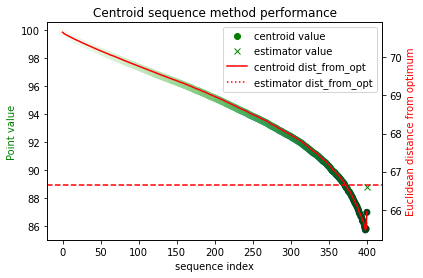

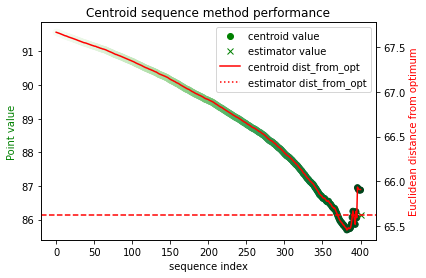

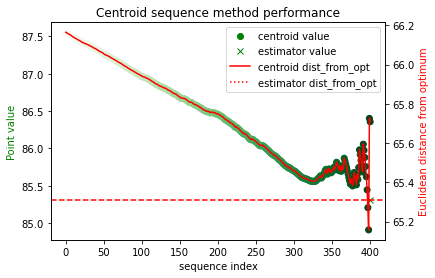

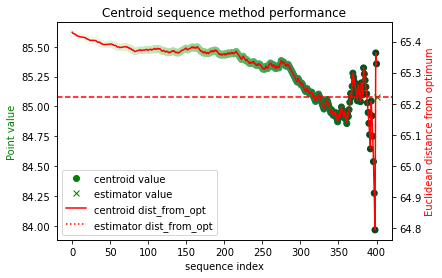

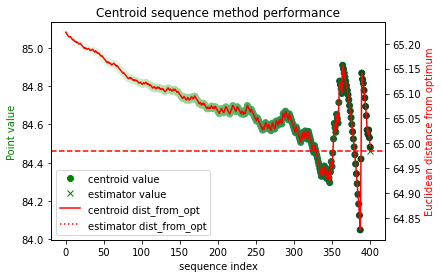

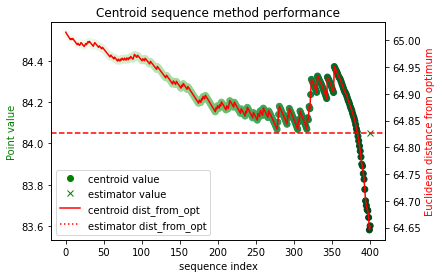

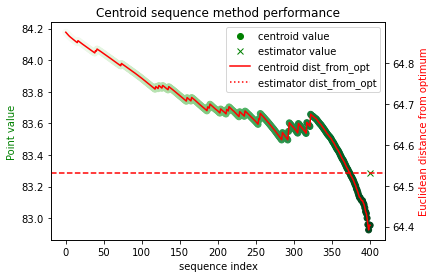

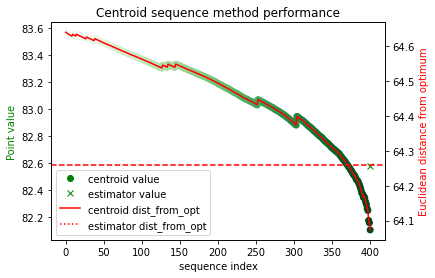

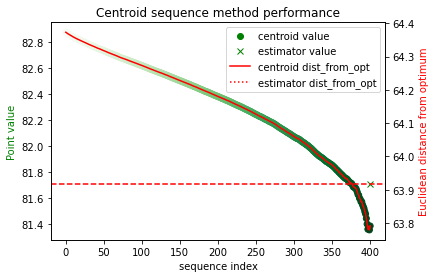

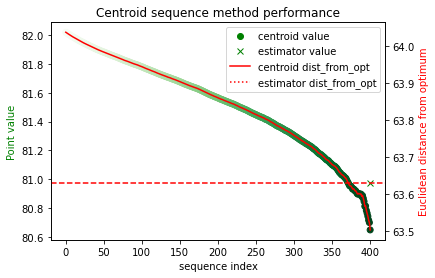

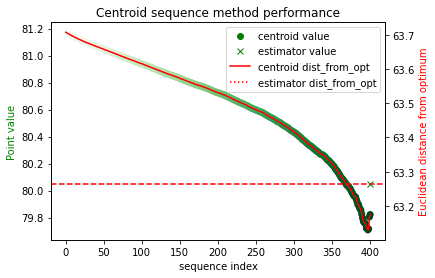

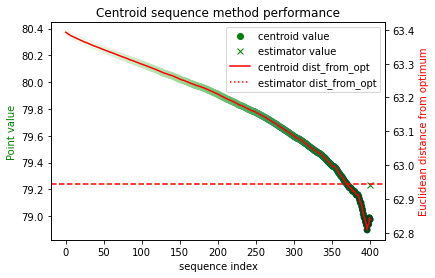

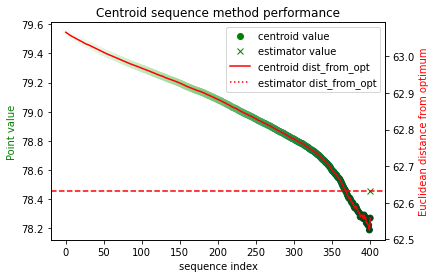

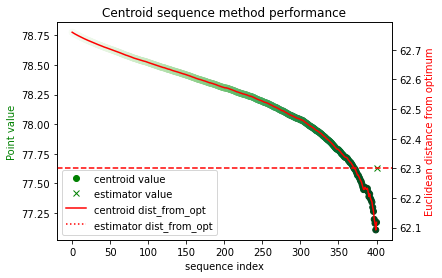

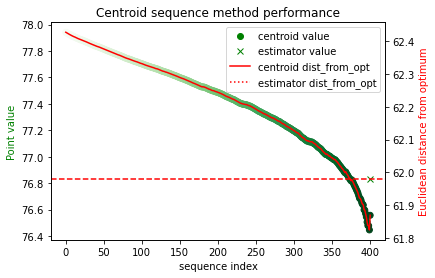

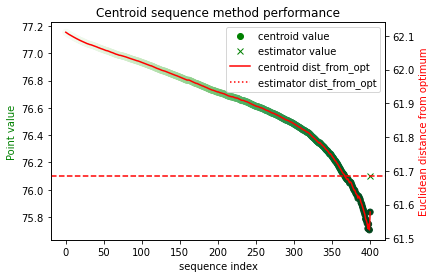

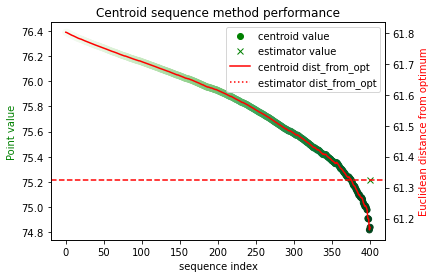

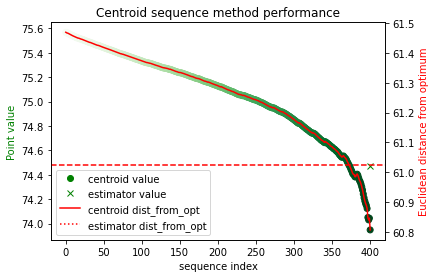

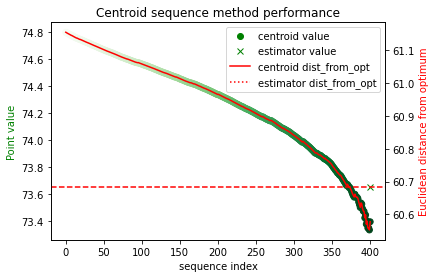

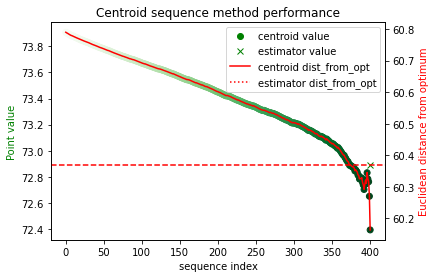

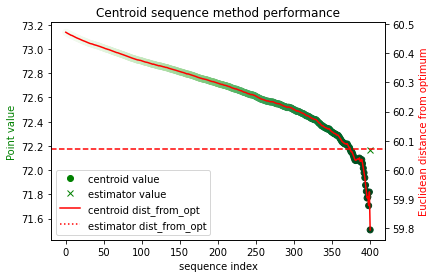

In [208]:
for population in H:
    plot_method_performance(population)